# **Multiclass clasification Monkey Species**

---

## **Introduction**

In this notebook, I will be using a dataset from Kaggle that contains images of Monkey Species. The dataset is devided into 10 different species including a train and a test dataset.

**The goal of this notebook will be to create a multiclass classification model that can classify the species of monkey based on an image.**


## **Table of Contents**

1. [Importing data and libraries](#1.-Importing-data-and-libraries)
2. [Data Exploration](#2.-Data-Exploration)
3. [Data Visualization](#3.-Data-Visualization)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Creating the Models](#5.-Creating-the-Models)  
   5.1 [Logistic Regression](#5.1-Logistic-Regression)  
   5.2 [Random Forest](#5.2-Random-Forest)  
   5.3 [Support Vector Machine](#5.3-Support-Vector-Machine)
6. [Conclusion](#6.-Conclusion)


## **1. Importing data and libraries**

---


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os

for dirname, _, _ in os.walk('.'):
    print(dirname)

train_path = './Training Data/'
test_path = './Prediction Data/'

.
.\Prediction Data
.\Prediction Data\Bald Uakari
.\Prediction Data\Emperor Tamarin
.\Prediction Data\Golden Monkey
.\Prediction Data\Gray Langur
.\Prediction Data\Hamadryas Baboon
.\Prediction Data\Mandril
.\Prediction Data\Proboscis Monkey
.\Prediction Data\Red Howler
.\Prediction Data\Vervet Monkey
.\Prediction Data\White Faced Saki
.\Training Data
.\Training Data\Bald Uakari
.\Training Data\Emperor Tamarin
.\Training Data\Golden Monkey
.\Training Data\Gray Langur


## **2. Data Exploration**

[Back to top](#Table-of-Contents)

---


In [24]:
total_train = sum([len(files) for _, _, files in os.walk(train_path)])
total_test = sum([len(files) for _, _, files in os.walk(test_path)])
print(f'Total training images: {total_train}')
print(f'Total testing images: {total_test}')

Total training images: 3655
Total testing images: 1304


We can see there are 10000 training images and 1306 test images, these images are devided in subfolders of each type of monkey

In [25]:
train_counts = {}
test_counts = {}

# Loop through the subdirectories in train_path
for subdir in os.listdir(train_path):
    subdir_path = os.path.join(train_path, subdir)
    if os.path.isdir(subdir_path):  # check if it's a directory
        num_images = len(os.listdir(subdir_path))
        train_counts[subdir] = num_images
        print(f'Train set {subdir} images: {num_images}')

print("")

# Loop through the subdirectories in test_path
for subdir in os.listdir(test_path):
    subdir_path = os.path.join(test_path, subdir)
    if os.path.isdir(subdir_path):  # check if it's a directory
        num_images = len(os.listdir(subdir_path))
        test_counts[subdir] = num_images
        print(f'Test set {subdir} images: {num_images}')

Train set Bald Uakari images: 1000
Train set Emperor Tamarin images: 1000
Train set Golden Monkey images: 1000
Train set Gray Langur images: 655

Test set Bald Uakari images: 54
Test set Emperor Tamarin images: 146
Test set Golden Monkey images: 35
Test set Gray Langur images: 89
Test set Hamadryas Baboon images: 42
Test set Mandril images: 101
Test set Proboscis Monkey images: 112
Test set Red Howler images: 156
Test set Vervet Monkey images: 161
Test set White Faced Saki images: 408


In the output you can see how many images there are in each sub folder


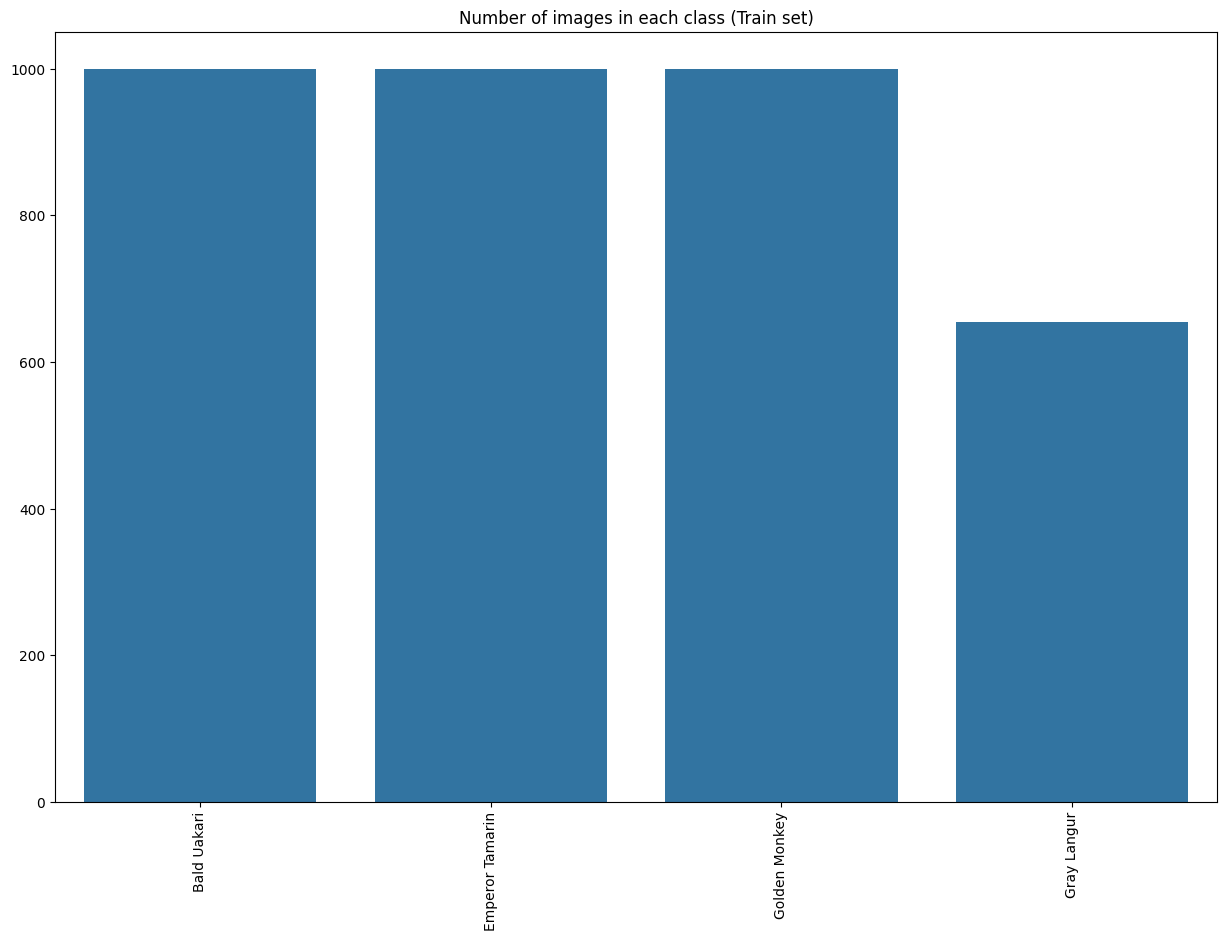

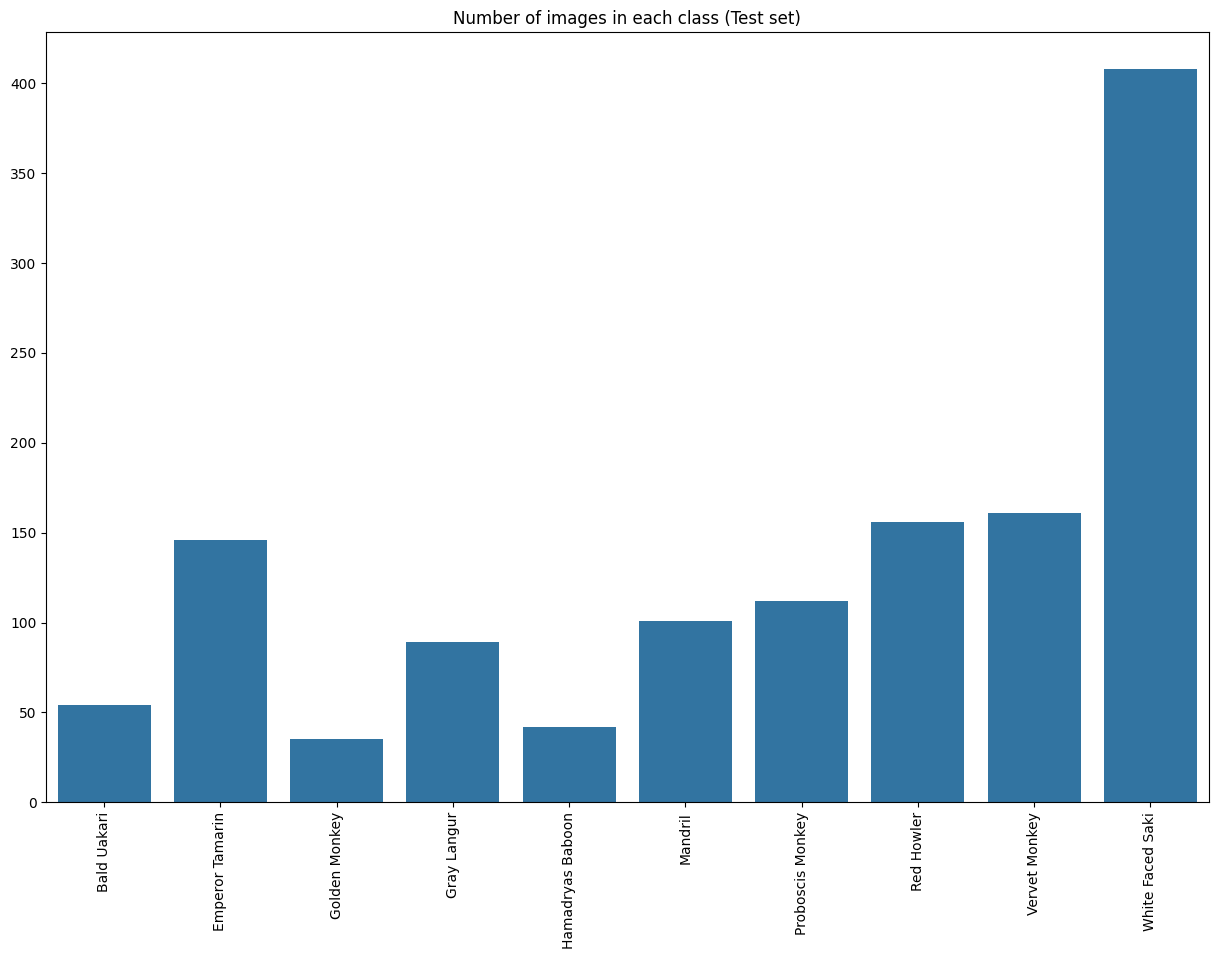

In [26]:
# Plot the train set counts
plt.figure(figsize=(15, 10))  # Increase figure size
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Number of images in each class (Train set)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Plot the test set counts
plt.figure(figsize=(15, 10))  # Increase figure size
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Number of images in each class (Test set)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()


## **3. Data Visualization**

[Back to top](#Table-of-Contents)

---

Now let's visualize some of the images in the training set to get a better understanding of the data.


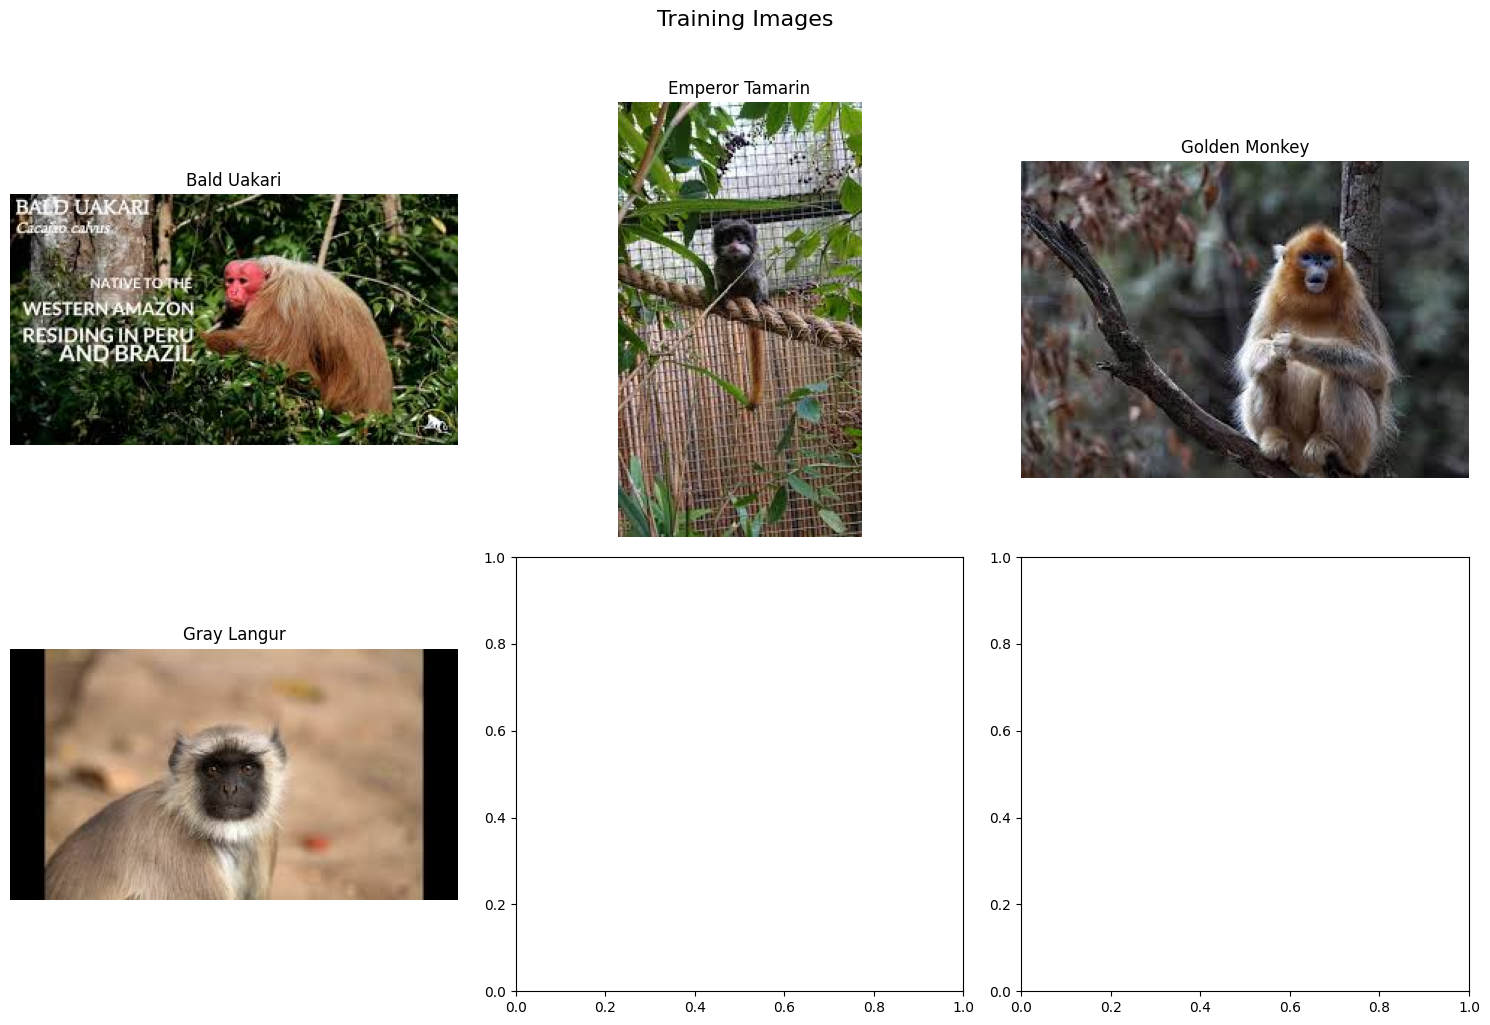

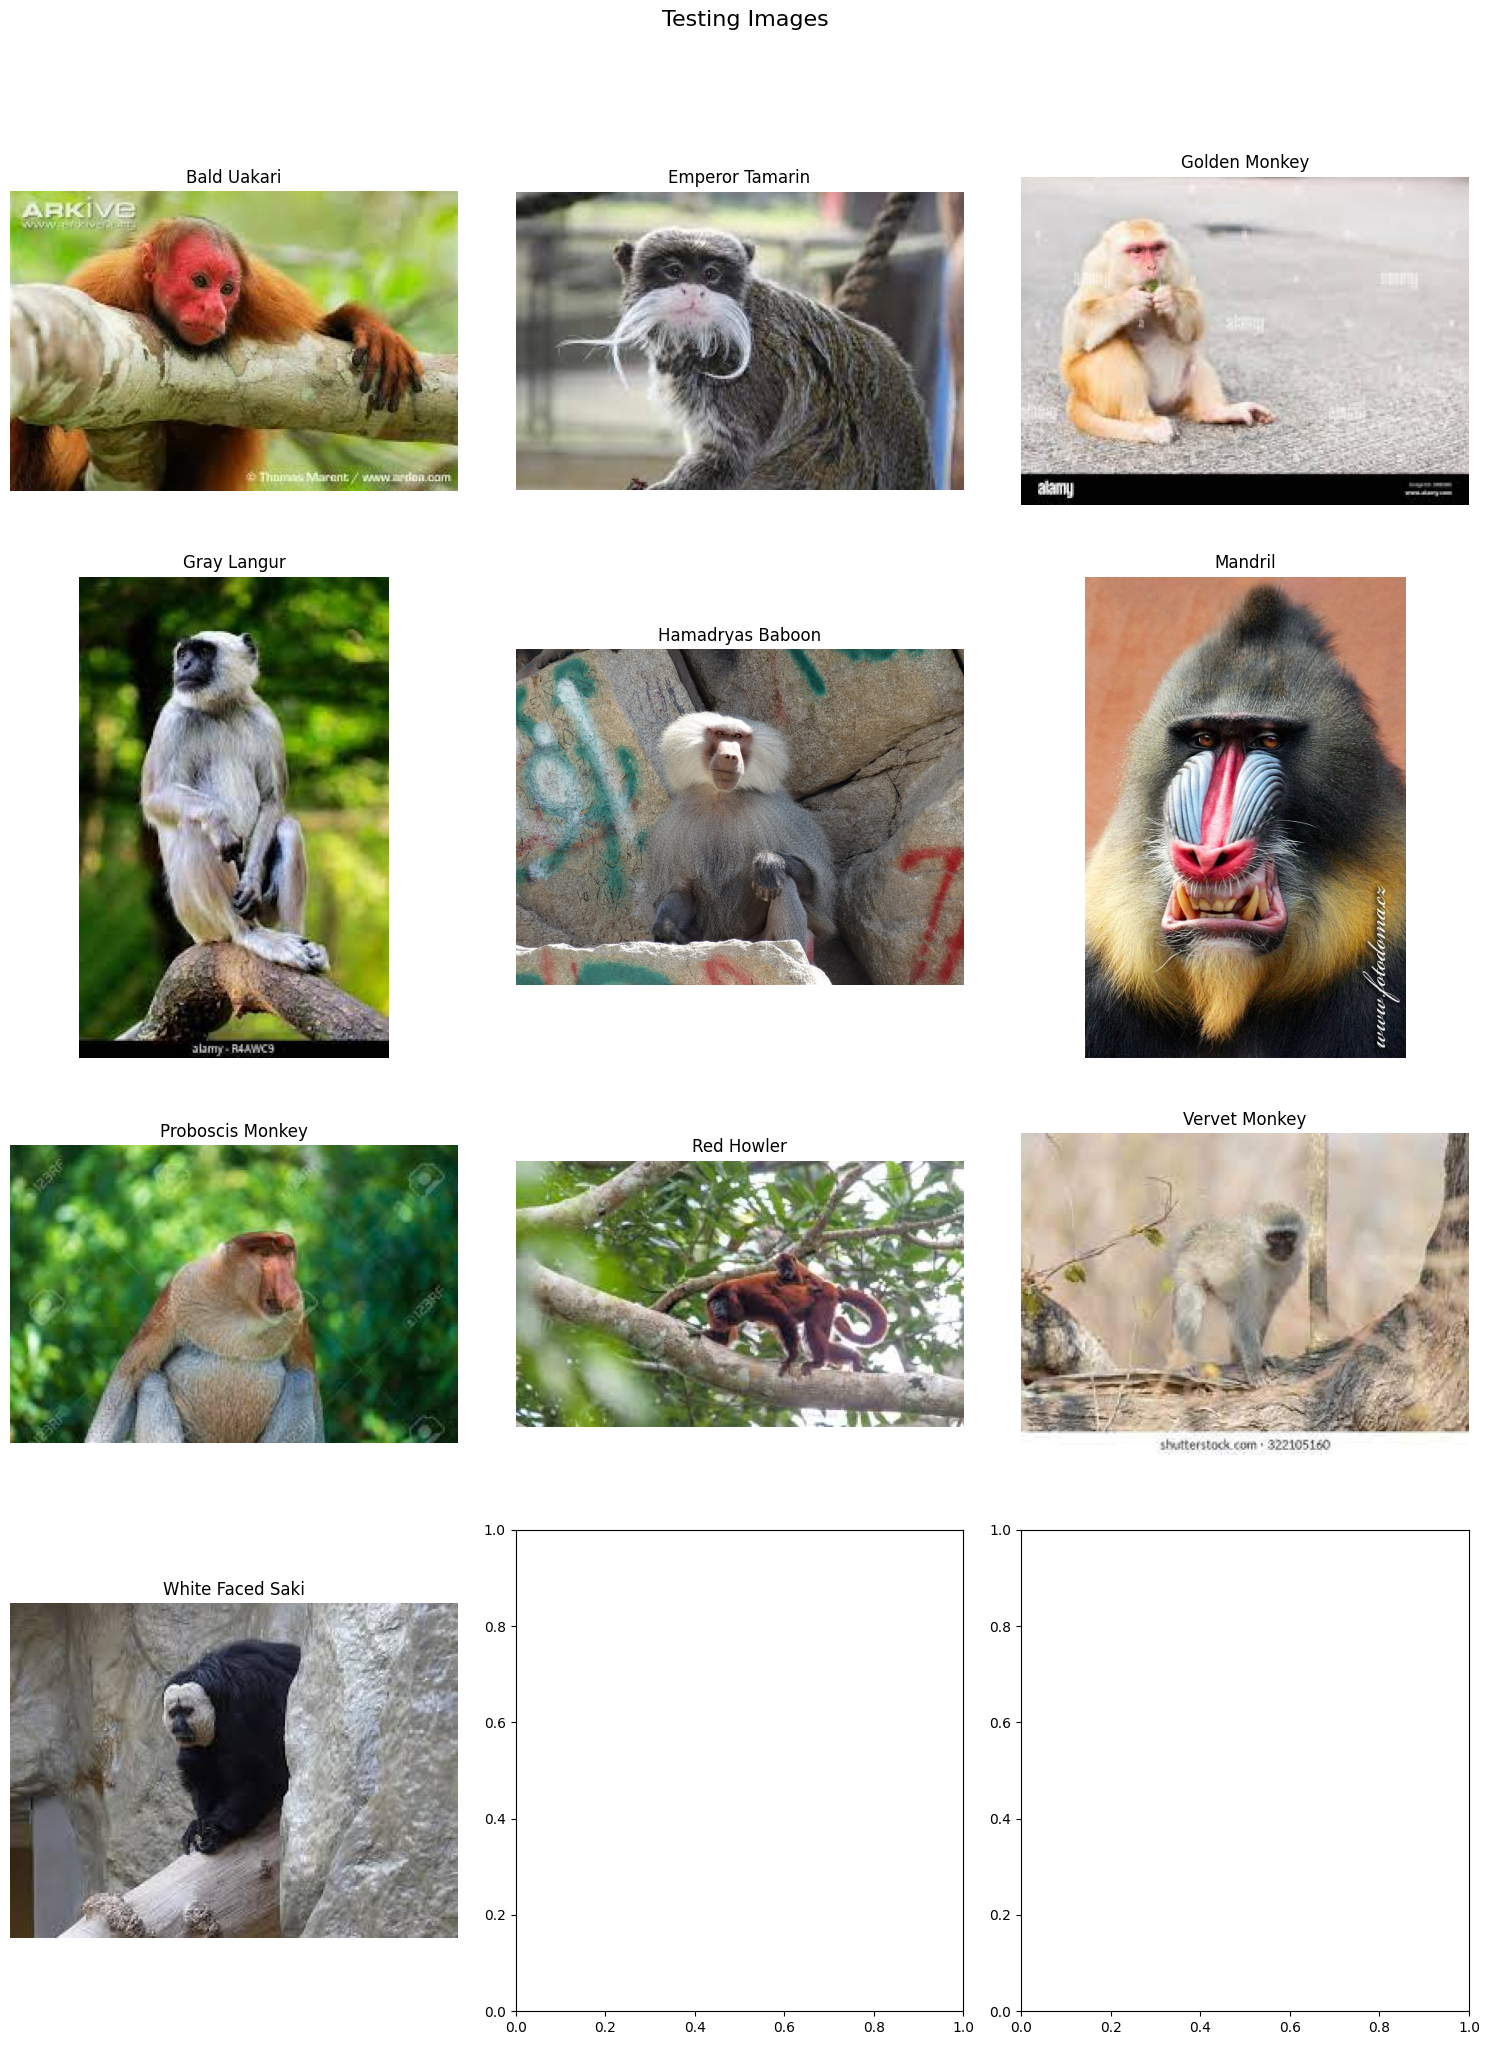

In [27]:
def show_images(path, label, ax):
    idx = np.random.randint(0, len(os.listdir(path)))
    img = cv2.imread(path + '/' + os.listdir(path)[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

def create_plot(path, title):
    n_subdirs = len(os.listdir(path))
    n_rows = math.ceil(n_subdirs / 3)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axs = axs.ravel()

    for i, subdir in enumerate(os.listdir(path)):
        subdir_path = os.path.join(path, subdir)
        if os.path.isdir(subdir_path):
            show_images(subdir_path, subdir, axs[i])

    plt.suptitle(title, fontsize=16, y=1.02)  # Adjust title spacing
    plt.tight_layout()
    plt.show()

# Create plots
create_plot(train_path, 'Training Images')
create_plot(test_path, 'Testing Images')


As we can see, the images are of different sizes and shapes. We will need to resize the images to a standard size before we can use them to train a model.


## **4. Data Preprocessing**

[Back to top](#Table-of-Contents)

---

Before we can use the images to train a model, we need to preprocess the data. This involves resizing the images to a standard size and converting them to arrays.

**I will only be using a subset of the training set to train the models. I will be using 1000 images of each monkey species. (It takes around 1 hour to run for Logistic Regression and Random Forest, for Support Vector Machine it takes around 5 hours)**


In [28]:
from tqdm import tqdm

def load_images(path, label, amount=1000):
    data = []
    labels = []
    for img in tqdm(os.listdir(path)[:amount]):
        img = cv2.imread(path + '/' + img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        labels.append(label)
    return data, labels

labels = os.listdir(train_path)  # Get the labels from the subdirectories
X_train = []
y_train = []
X_test = []
y_test = []

for i, label in enumerate(labels):
    train_subdir = os.path.join(train_path, label)
    test_subdir = os.path.join(test_path, label)
    
    train_data, train_labels = load_images(train_subdir, i)
    test_data, test_labels = load_images(test_subdir, i)
    
    X_train.extend(train_data)
    y_train.extend(train_labels)
    X_test.extend(test_data)
    y_test.extend(test_labels)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)


100%|██████████| 89/89 [00:02<00:00, 38.06it/s] 


Train set: (3655, 224, 224, 3) (3655,)
Test set: (324, 224, 224, 3) (324,)


The function load_images takes the path to a directory and a label as input. It then loads the images from the directory, resizes them to 224x224, and appends them to a list. It also appends the label to a separate list. The function returns the list of images and the list of labels.


In [29]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 224 * 224 * 3)
X_test = X_test.reshape(-1, 224 * 224 * 3)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (3655, 150528) (3655,)
Test set: (324, 150528) (324,)


Then we normalize the pixel values by dividing them by 255.0. We also reshape the images to a single dimension. This is because the models we will be using require the input to be a single dimension. The steps left before we can train a model are to split the training set into a training and validation set and to encode the labels.


In [30]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## **5. Creating the models**

[Back to top](#Table-of-Contents)

---

Now that the data is preprocessed, I will create three sklearn models to classify the monkey species images:

- Logistic Regression
- Random Forest
- Support Vector Machine

I predict that the Random Forest model will perform the best, because it is an ensemble method that is robust to overfitting and can handle non-linear relationships between the features and the target variable. I will evaluate the models using the accuracy score, confusion matrix, and cross-validation score.


#### **5.1 Logistic Regression**


In [31]:
def copy_data():
    """Returns a copy of the data. To avoid modifying the original data."""
    return X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy()

X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = LogisticRegression(max_iter=1000)

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.7438271604938271


The accuracy of the logistic regression model is 74.3%. This is a good result, but we can probably do better with a different model.


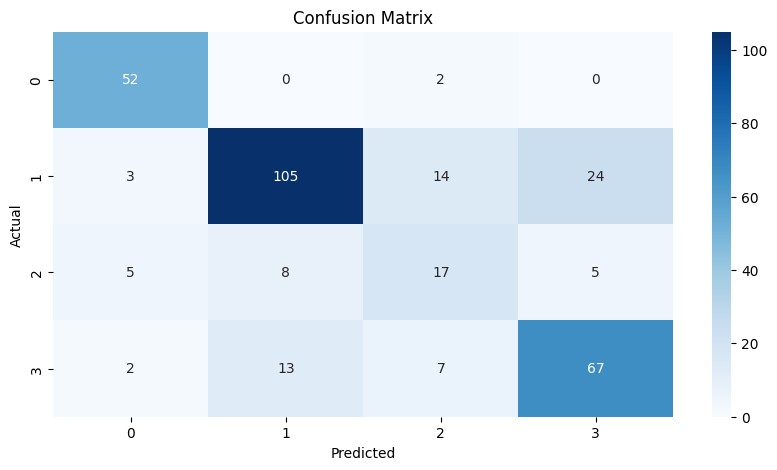

In [32]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test_copy, y_pred)

The confusion matrix shows the predicted value and the actual value, it mostly predicts the species correctly but monkey species 2 has some difficulties, this is probably due to the lack of images of that paricular species.


In [33]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.69357045 0.73461012 0.71409029 0.70998632 0.69767442]
Mean cross-validation score: 0.7099863201094391


The mean cross-validation score is 70.4%, which is close to the accuracy of the model. This means that the model is not overfitting the training data.


#### **5.2 Random Forest**


In [34]:
X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.8240740740740741


The accuracy of the random forest model is 82.4%. Which is higher than the accuracy of the logistic regression model. This is what I expected, because the random forest model is an ensemble method that is robust to overfitting and can handle non-linear relationships between the features and the target variable.

> Ensemble methods are machine learning algorithms that rely on the "wisdom of the crowd". They combine the predictions of multiple models to improve the accuracy of the predictions.


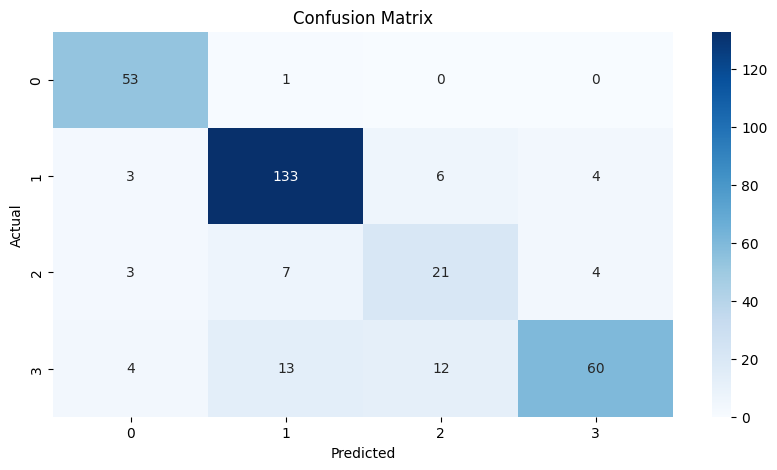

In [35]:
plot_confusion_matrix(y_test_copy, y_pred)

The confusion matrix shows the predicted value and the actual value, it mostly predicts the species correctly but monkey species 2 has some difficulties, this is probably due to the lack of images of that paricular species. This model compared to the previous one predicts less species wrong.


In [36]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.73871409 0.75923393 0.75923393 0.74555404 0.75239398]
Mean cross-validation score: 0.7510259917920656


The mean cross-validation score is 75.1%, which is close to the accuracy of the model. This means that the model is unlikely to be overfitting the training data.


#### **5.3 Support Vector Machine**


In [37]:
X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = SVC()

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.8117283950617284


The accuracy of the support vector machine model is 81.1%. This is the roughly the same as random forest.

I'm guessing that the support vector machine model is performing the best same as random forest because it is effective for multiclass image classification due to its ability to find the optimal hyperplane that best separates different classes in high-dimensional feature spaces. This is crucial for distinguishing between different monkey species based on visual features. In contrast, Logistic Regression may struggle with multiclass image classification in this context due to their decision tree-based approach, which might not effectively capture the complex relationships between features in images without extensive feature engineering or pre-processing.


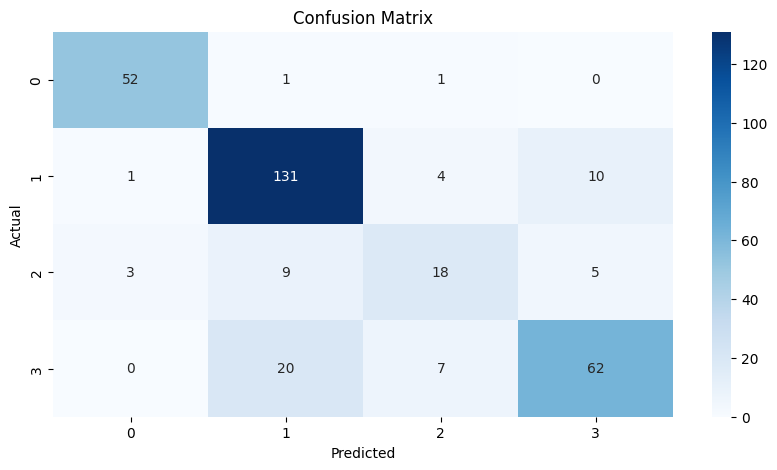

In [38]:
plot_confusion_matrix(y_test_copy, y_pred)

The confusion matrix shows the predicted value and the actual value, it mostly predicts the species correctly but monkey species 2 has some difficulties, this is probably due to the lack of images of that paricular species. It gets a bit more wrong than the random forest model, so it is arguably worse.


In [39]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.74281806 0.77291382 0.75649795 0.75102599 0.78112175]
Mean cross-validation score: 0.7608755129958961


The mean cross-validation score is 76.8%, which is close to the accuracy of the model. This means that the model is not overfitting the training data. 


## **6. Conclusion**

[Back to top](#Table-of-Contents)

---
In this notebook, I developed three models to classify images of monkey species into ten different categories. The models used were Logistic Regression, Random Forest, and Support Vector Machine (SVM). The Random Forest model achieved the highest accuracy at 82.4%, followed closely by the SVM at 81.1%, and the Logistic Regression model at 74.3%.

Although my initial prediction favored the Random Forest model due to its ensemble nature and robustness to overfitting, the actual performance difference between Random Forest and SVM was marginal. This suggests that both methods are quite effective for this type of image classification. The confusion matrices revealed that species 2 was consistently misclassified, likely due to a smaller number of images for that category, indicating that model performance could be improved with a more balanced dataset.

Future improvements could involve exploring convolutional neural networks (CNNs), which are specifically designed for image data and might capture more complex patterns in the images, potentially leading to higher accuracy. Additionally, increasing the size of the training set and employing data augmentation techniques could help improve the model's ability to generalize.

Overall, this project demonstrates the feasibility of using machine learning models for multiclass image classification and highlights the importance of model selection and data preprocessing in achieving optimal results.

If i have to recommend a model for this type of project i still would recommend Random Forest because eventhough its a small difference, this model is still more accurate and takes 3 to 4 times less time to run as opposed to Support Vector Machine.